## Imports

In [150]:
import numpy as np
import math
import pandas as pd
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [151]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [152]:
import shap
plt.rcParams["figure.figsize"] = (20, 15)

In [153]:
train_monthly = pd.read_pickle("train_monthly.pkl")

## Data preprocessing

In [154]:
# Dropping some features due to data leakage leding to significant -
# - overfitting or which are not helping in improving model accuracy

train_monthly.drop(
    [
        "mean_item_cnt",
        "transactions",
        "qmean_rev",
        "mean_item_cnt_lag_2",
        "mean_item_cnt_lag_3",
        "revenue_lag_1",
        "revenue_lag_2",
        "revenue_lag_3",
        "item_cnt_min",
        "transactions_lag_2",
        "transactions_lag_3",
        "transactions_lag_6",
        "item_cnt_max",
        "item_cnt_mean",
        "date_shop_type_avg_item_cnt_lag_1",
        "date_shop_type_avg_item_cnt_lag_2",
        "date_shop_type_avg_item_cnt_lag_3",
        "date_item_city_avg_item_cnt_lag_3",
        "date_type_avg_item_cnt_lag_3",
        "date_shop_subcat_avg_item_cnt_lag_3",
        "date_subtype_avg_item_cnt_lag_3",
        "date_shop_cat_avg_item_cnt_lag_3",
        "year",
        
    ],
    axis=1,
    inplace=True,
)

In [155]:
# Hence doesnt provide historic information for model to learn
train_monthly = train_monthly.loc[train_monthly["date_block_num"] > 5]
cat_cols = [
    "shop_id",
    "item_id",
    "item_category_id",
    "city_code",
    "type_code",
    "subcat_code",
    "month",
]

# Lightgbm has in built categorical feature encoding however require such feature as category type
train_monthly[cat_cols] = train_monthly[cat_cols].astype("category")

## Cross Validation function

In [156]:
def cross_validation(model,train_monthly):
    print(f"Validating model {model}")
    tscv = TimeSeriesSplit(n_splits = 5)
    rmse = []
    for train_splits, test_splits in tscv.split(train_monthly):  
        train_df = train_monthly.iloc[train_splits, :]
        test_df = train_monthly.iloc[test_splits, :]
        X_train = train_df.drop(["item_cnt"], axis=1)
        y_train = train_df["item_cnt"]
        X_val = test_df.drop(["item_cnt"], axis=1)
        y_val = test_df["item_cnt"]
        print("Split is on ", train_df[-1:].date_block_num.values[0]," month.")
        model(X_train,y_train,X_val,y_val)

## Different models

In [157]:
def train_model_linear_regression(X_train,y_train,X_val,y_val):
    linreg = LinearRegression().fit(X_train, y_train)
    print("Train rmse score: ",math.sqrt(mse(y_train,linreg.predict(X_train))))
    y_pred = linreg.predict(X_val)
    print("Validation rmse score: ", math.sqrt(mse(y_val,y_pred)))
    return linreg

In [158]:
def train_model_ridge_regression(X_train,y_train,X_val,y_val):
    ridge = Ridge().fit(X_train, y_train)
    print("Train rmse score: ",math.sqrt(mse(y_train,ridge.predict(X_train))))
    y_pred = ridge.predict(X_val)
    print("Validation rmse score: ", math.sqrt(mse(y_val,y_pred)))
    return ridge

In [159]:
def train_model_decision_tree_regressor(X_train,y_train,X_val,y_val):
    regressor = DecisionTreeRegressor().fit(X_train, y_train)
    print("Train rmse score: ",math.sqrt(mse(y_train,regressor.predict(X_train))))
    y_pred = regressor.predict(X_val)
    print("Validation rmse score: ", math.sqrt(mse(y_val,y_pred)))
    return regressor

In [160]:
def train_model_random_forest_regressor(X_train,y_train,X_val,y_val):
    X_train, y_train = make_regression(n_features = 52)
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    print("Train rmse score: ",math.sqrt(mse(y_train,regr.predict(X_train))))
    y_pred = regr.predict(X_val)
    print("Validation rmse score: ", math.sqrt(mse(y_val,y_pred)))
    return regr

In [161]:
def train_model_gradient_boosting(X_train,y_train,X_val,y_val):
    final_feat = X_train.columns.tolist()

    params = {
        "objective": "mse",
        "metric": "rmse",
        "num_leaves": 250,
        "learning_rate": 0.005,  # Keeping small learning rate for better convergence
        "feature_fraction": 0.75,  # Keeping around 75% to induce generalisation in the model
        "bagging_fraction": 0.75,  # Keeping around 75% to induce generalisation in the model
        "bagging_freq": 5,
        "seed": 1,
        "verbose": 1,
        "force_row_wise": True,
    }

    lgb_train = lgb.Dataset(X_train[final_feat], y_train, categorical_feature=None)
    lgb_eval = lgb.Dataset(
        X_val[final_feat], y_val, categorical_feature=None, reference=lgb_train
    )

    evals_result = {}
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=(lgb_train, lgb_eval),
        feature_name=final_feat,
        categorical_feature=cat_cols,
        verbose_eval=100,
        evals_result=evals_result,
    )
    return gbm

## Applying cross-validation to all models

In [162]:
for model in [train_model_linear_regression, train_model_ridge_regression, train_model_decision_tree_regressor, train_model_random_forest_regressor, train_model_gradient_boosting]:
    cross_validation(model,train_monthly)

Validating model <function train_model_linear_regression at 0x000001972B1AFE50>
Split is on  10  month.
Train rmse score:  2.194242002874549
Validation rmse score:  2.278787479755619
Split is on  15  month.
Train rmse score:  2.2080223001223
Validation rmse score:  2.035924009660694
Split is on  20  month.
Train rmse score:  2.1356381378598805
Validation rmse score:  11.152976320559883
Split is on  25  month.
Train rmse score:  2.1811375864993816
Validation rmse score:  1.9306002770503543
Split is on  33  month.
Train rmse score:  2.1299675663334896
Validation rmse score:  157626292381.51535
Validating model <function train_model_ridge_regression at 0x000001974A8AE1F0>
Split is on  10  month.
Train rmse score:  2.194242003109346
Validation rmse score:  2.2787837874809274
Split is on  15  month.
Train rmse score:  2.2080090052230683
Validation rmse score:  2.036019594465477
Split is on  20  month.
Train rmse score:  2.13559831373191
Validation rmse score:  11.030066313874707
Split is on

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Total Bins 17021
[LightGBM] [Info] Number of data points in the train set: 245224, number of used features: 49


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 2.029275
[100]	training's rmse: 1.93333	valid_1's rmse: 2.2535
[200]	training's rmse: 1.52564	valid_1's rmse: 1.99171
[300]	training's rmse: 1.29338	valid_1's rmse: 1.87738
[400]	training's rmse: 1.15645	valid_1's rmse: 1.82294
[500]	training's rmse: 1.07209	valid_1's rmse: 1.7962
[600]	training's rmse: 1.01595	valid_1's rmse: 1.7848
[700]	training's rmse: 0.975983	valid_1's rmse: 1.77676
[800]	training's rmse: 0.944375	valid_1's rmse: 1.77249
[900]	training's rmse: 0.918386	valid_1's rmse: 1.76875
[1000]	training's rmse: 0.895382	valid_1's rmse: 1.76732
Split is on  15  month.
[LightGBM] [Info] Total Bins 18224
[LightGBM] [Info] Number of data points in the train set: 490447, number of used features: 49
[LightGBM] [Info] Start training from score 2.098924
[100]	training's rmse: 2.0066	valid_1's rmse: 1.99929
[200]	training's rmse: 1.60234	valid_1's rmse: 1.7839
[300]	training's rmse: 1.37473	valid_1's rmse: 1.68877
[400]	training's rmse: 1.2

# Modeling

In [163]:
# Train-Validation-Test Split - Take 1 month of data as validation and month = 33 as our test since we dont have data for month = 34
X_train = train_monthly.loc[train_monthly["date_block_num"] < 33].drop(
    ["item_cnt"], axis=1
)
y_train = train_monthly.loc[train_monthly["date_block_num"] < 33]["item_cnt"]

X_val = train_monthly.loc[train_monthly["date_block_num"] == 33].drop(
    ["item_cnt"], axis=1
)
y_val = train_monthly.loc[train_monthly["date_block_num"] == 33]["item_cnt"]

X_test = train_monthly.loc[train_monthly["date_block_num"] == 34].drop(
    ["item_cnt"], axis=1
)
y_test = train_monthly.loc[train_monthly["date_block_num"] == 34]["item_cnt"]

## Linear regression and feature importance

In [164]:
lr = train_model_linear_regression(X_train,y_train,X_val,y_val)

Train rmse score:  2.13004512224432
Validation rmse score:  2.2960094586752593


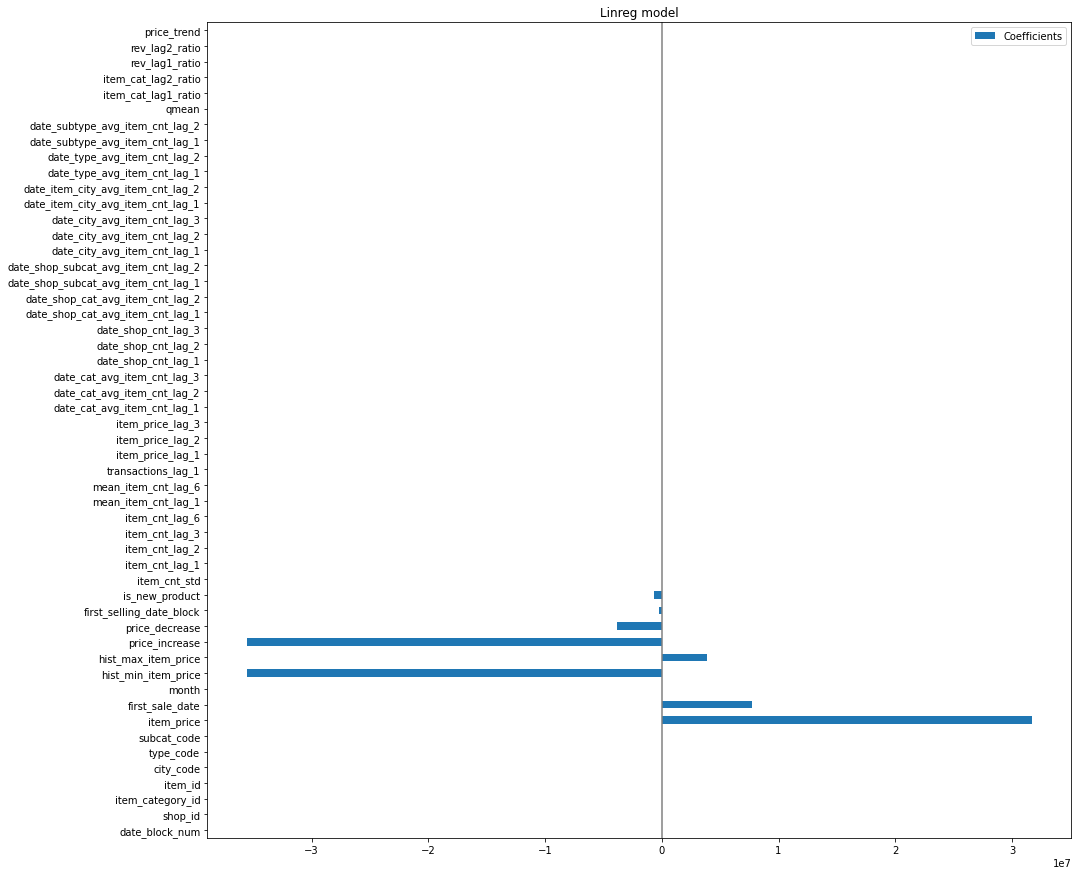

In [165]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   lr.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(20, 15))
plt.title('Linreg model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Ridge regression and feature importance

In [166]:
ridge = train_model_ridge_regression(X_train,y_train,X_val,y_val)

Train rmse score:  2.1300451725917777
Validation rmse score:  2.2960148050224696


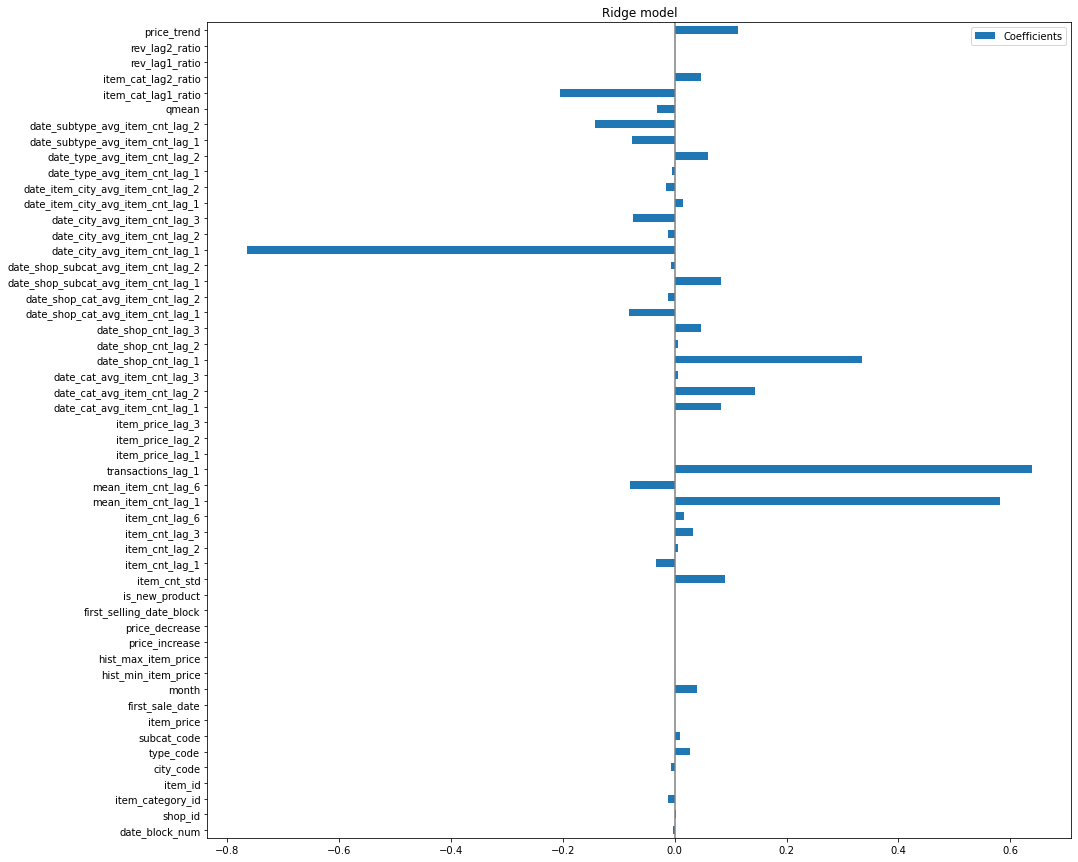

In [167]:
coefs = pd.DataFrame(
   ridge.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(20, 15))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Decision tree regressor and feature importance

In [168]:
dtree = train_model_decision_tree_regressor(X_train,y_train,X_val,y_val)

Train rmse score:  0.0
Validation rmse score:  2.2914851865039405


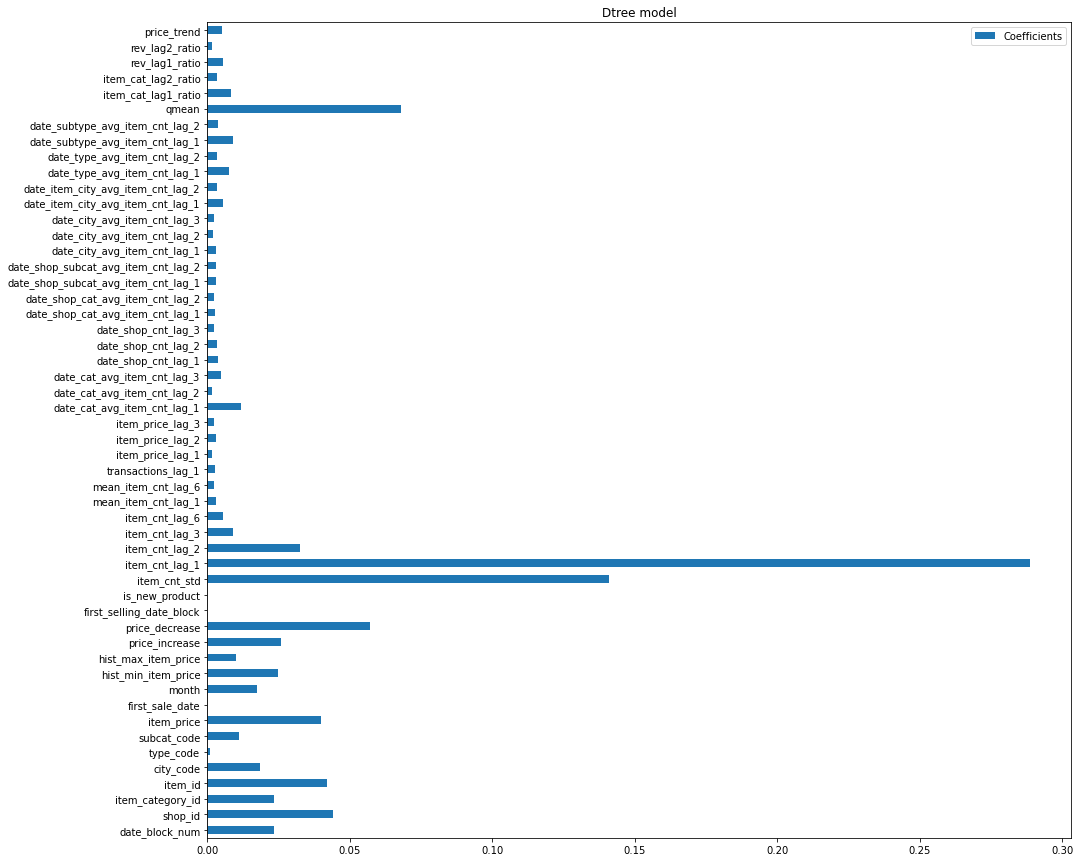

In [169]:
coefs = pd.DataFrame(
   dtree.feature_importances_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(20, 15))
plt.title('Dtree model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## LGBM and feature importance

In [170]:
best_model = train_model_gradient_boosting(X_train,y_train,X_val,y_val)

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Total Bins 20318
[LightGBM] [Info] Number of data points in the train set: 1225625, number of used features: 49
[LightGBM] [Info] Start training from score 2.040273

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.



[100]	training's rmse: 1.96504	valid_1's rmse: 2.15618
[200]	training's rmse: 1.6032	valid_1's rmse: 1.96329
[300]	training's rmse: 1.3988	valid_1's rmse: 1.87757
[400]	training's rmse: 1.27837	valid_1's rmse: 1.83181
[500]	training's rmse: 1.20402	valid_1's rmse: 1.80972
[600]	training's rmse: 1.15426	valid_1's rmse: 1.79636
[700]	training's rmse: 1.11773	valid_1's rmse: 1.78379
[800]	training's rmse: 1.08773	valid_1's rmse: 1.77427
[900]	training's rmse: 1.06307	valid_1's rmse: 1.76741
[1000]	training's rmse: 1.04309	valid_1's rmse: 1.7635


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

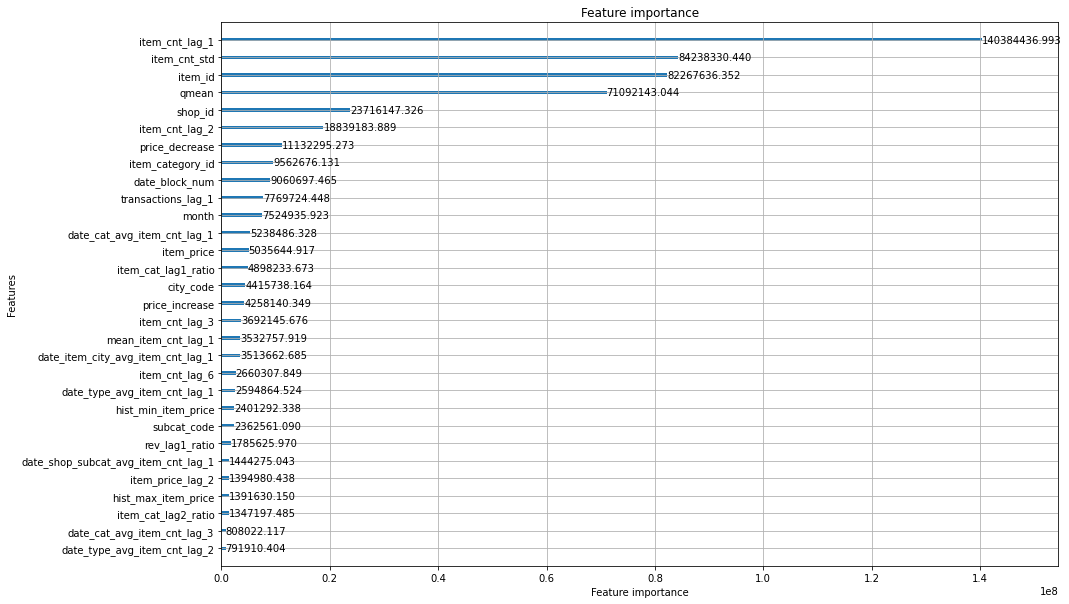

In [171]:
lgb.plot_importance(best_model, max_num_features=30, 
                    importance_type="gain", 
                    figsize=(15, 10))

# SHAP tbd
